In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metric as mc
from neuralforecast import NeuralForecast
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle, ConnectionPatch
from scipy.stats import chi2_contingency as chi
from statsmodels.tsa.stattools import grangercausalitytests
from IPython.display import clear_output
import torch
import warnings
import scipy.stats as stats
import seaborn as sns
warnings.filterwarnings("ignore")

In [4]:
import torch
print(torch.__version__)        # 检查 PyTorch 版本
print(torch.version.cuda)       # 检查 PyTorch 支持的 CUDA 版本


2.3.1+cpu
None


In [2]:
path = 'data_LPG.xlsx'
df=pd.read_excel(path,engine="openpyxl",index_col='ds')
df = df[['unique_id','y','WTI','BRENT','沙特阿美预测CP(丙烷)','沙特阿美预测CP(丁烷)','open','high','low','close','settle','vol','amount','oi','乙烯价格','中国:中间价:美元兑人民币']]
df.columns = ['unique_id','y','WTI','BRENT','CP_P','CP_B','open','high','low','close','settle','vol','amount','oi','C2H4','exchange']
df['unique_id'].replace('华南', 'Southern_China', inplace=True)
df['unique_id'].replace('华东', 'Eastern_China', inplace=True)
df['unique_id'].replace('华中', 'Central_China', inplace=True)
df['unique_id'].replace('山东', 'ShanDong', inplace=True)
df['unique_id'].replace('华北', 'Northern_China', inplace=True)
df['unique_id'].replace('西部', 'Western_China', inplace=True)
df = df[df.index < '2024-01-16']
uids = df['unique_id'].unique()

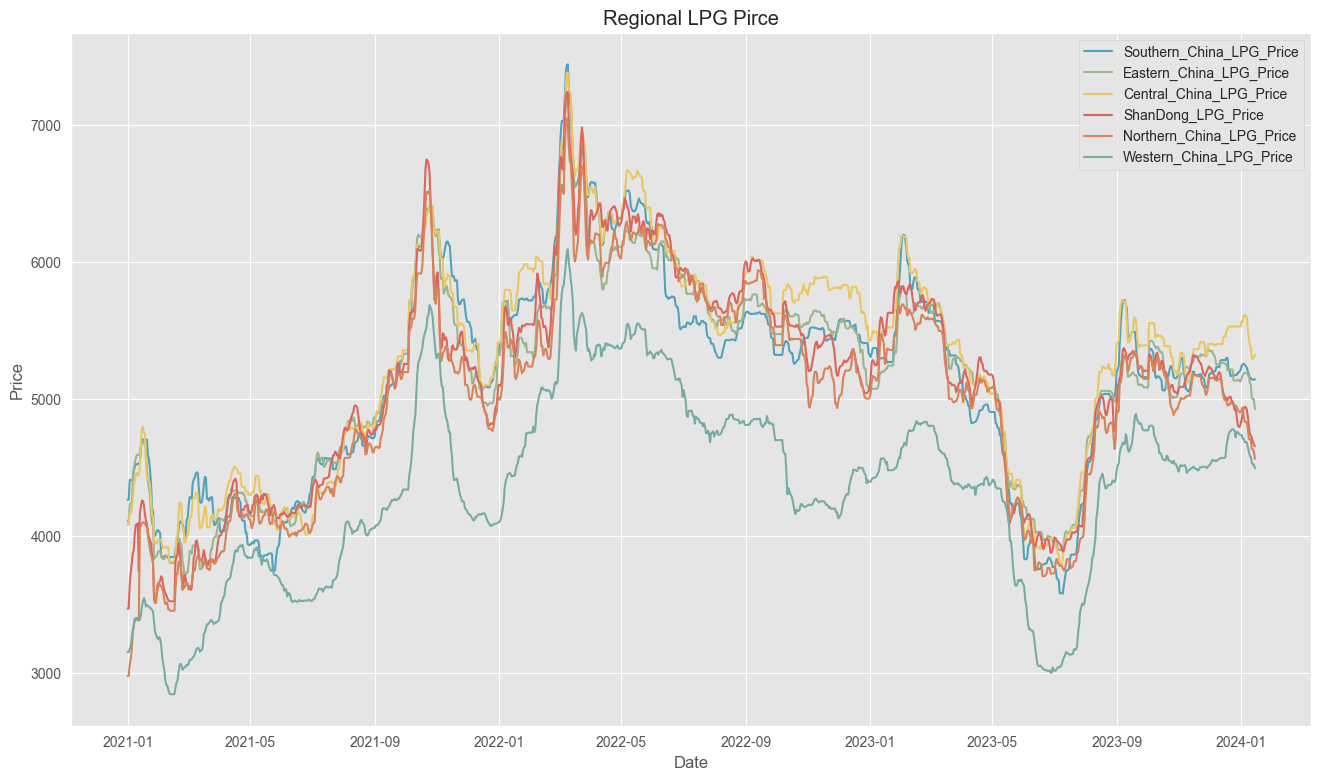

In [3]:
dic = {'Western_China': '#77aca4',
 'Central_China': '#eac763',
 'Southern_China': '#50a3ba',
 'Eastern_China': '#9db58f',
 'Northern_China': '#d7845b',
 'ShanDong': '#dc665e'}
plt.figure(figsize=(16,9))
plt.style.use('ggplot')
for i in uids:
    plt.plot(df[df['unique_id'] == i]['y'], label = f'{i}_LPG_Price',color=dic[i])
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Regional LPG Pirce')
plt.legend()
plt.show()

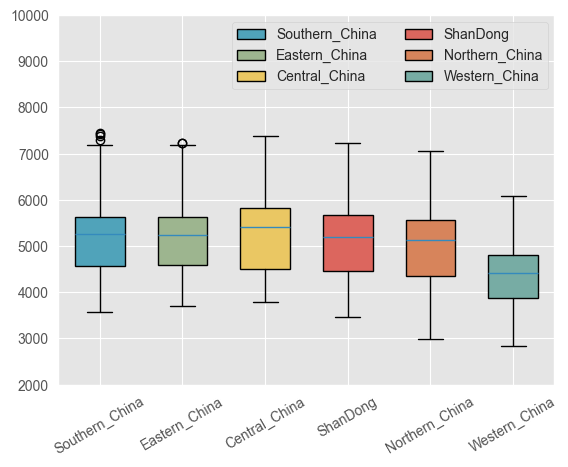

In [4]:
k=0
dic = {'Western_China': '#77aca4',
 'Central_China': '#eac763',
 'Southern_China': '#50a3ba',
 'Eastern_China': '#9db58f',
 'Northern_China': '#d7845b',
 'ShanDong': '#dc665e'}
for i in uids:
    plt.boxplot(df[df['unique_id'] == i]['y'], positions=[k],patch_artist=True,
                boxprops=dict(facecolor=dic[i]), label=i, widths=0.6)
    k+=1
plt.xticks(range(len(uids)),uids, rotation=30)
plt.ylim(2000,10000)
plt.legend(ncol=2)
plt.show()

In [5]:
for i in uids:
    stat, p = stats.shapiro(df[df['unique_id'] == i]['y'])
    print(f'{i} - Shapiro Test: Statistics={stat}, p-value={p}')

Southern_China - Shapiro Test: Statistics=0.9751718640327454, p-value=7.310898306016334e-13
Eastern_China - Shapiro Test: Statistics=0.9686011672019958, p-value=9.157661133856083e-15
Central_China - Shapiro Test: Statistics=0.9562373757362366, p-value=1.0546255852211196e-17
ShanDong - Shapiro Test: Statistics=0.9773241877555847, p-value=3.627987884072259e-12
Northern_China - Shapiro Test: Statistics=0.9762384295463562, p-value=1.5978933671015327e-12
Western_China - Shapiro Test: Statistics=0.9797387719154358, p-value=2.473540643144201e-11


In [6]:
h_value, p_value = stats.kruskal(df[df['unique_id']=='Southern_China']['y'], df[df['unique_id']=='Eastern_China']['y'], df[df['unique_id']=='Central_China']['y'], df[df['unique_id']=='ShanDong']['y'], df[df['unique_id']=='Northern_China']['y'], df[df['unique_id']=='Western_China']['y'])
print(f'Kruskal-Wallis H-value={h_value}, p-value={p_value}')

Kruskal-Wallis H-value=889.8519340242475, p-value=4.1818305788867757e-190


In [7]:
data_des = pd.DataFrame()
for i in uids:
    data = df[df['unique_id']==i]['y']
    description = data.describe()
    kurtosis_value = stats.kurtosis(data)
    skewness_value = stats.skew(data)
    description['kurtosis'] = kurtosis_value
    description['skewness'] = skewness_value
    data_des[f'{i}_LPG_Price'] = description
for i in df.columns.drop(['unique_id', 'y']):
    data = df[df['unique_id'] == 'Southern_China'][i]
    description = data.describe()
    kurtosis_value = stats.kurtosis(data)
    skewness_value = stats.skew(data)
    description['kurtosis'] = kurtosis_value
    description['skewness'] = skewness_value
    data_des[i] = description
data_des

,Southern_China_LPG_Price,Eastern_China_LPG_Price,Central_China_LPG_Price,ShanDong_LPG_Price,Northern_China_LPG_Price,Western_China_LPG_Price,WTI,BRENT,CP_P,CP_B,open,high,low,close,settle,vol,amount,oi,C2H4,exchange
count,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1.110000e+03,1110.000000,1110.000000,1110.000000
mean,5160.724324,5155.272973,5288.270270,5126.419820,5009.704505,4350.958559,79.832721,83.858604,642.372973,636.219820,4868.230631,4940.980180,4789.263964,4870.318018,4864.901802,126024.615315,1.253259e+06,59697.245045,7707.504505,6.743851
std,770.159945,718.472231,782.263887,779.779783,776.537609,680.632111,14.032225,14.218861,114.136961,118.318625,733.033083,752.434820,710.461437,730.603206,730.001725,55564.013296,6.331557e+05,25062.385684,773.642540,0.307247
min,3579.000000,3701.000000,3784.000000,3470.000000,2978.000000,2845.000000,47.620000,51.090000,421.000000,399.000000,3302.000000,3342.000000,3253.000000,3264.000000,3298.000000,26096.000000,2.040750e+05,10923.000000,6313.000000,6.301400
25%,4565.000000,4594.750000,4497.500000,4452.750000,4348.500000,3884.750000,71.230000,74.390000,570.000000,558.000000,4345.500000,4413.000000,4293.000000,4354.000000,4355.500000,83149.750000,7.839934e+05,44759.000000,7138.000000,6.460500
50%,5270.000000,5243.000000,5414.000000,5206.000000,5126.000000,4418.500000,77.855000,82.670000,619.000000,620.000000,4889.000000,4962.000000,4823.500000,4879.500000,4902.500000,114669.500000,1.166135e+06,57693.000000,7567.000000,6.735300
75%,5621.000000,5636.000000,5834.000000,5661.500000,5557.250000,4800.000000,87.350000,92.355000,711.000000,705.750000,5319.500000,5409.000000,5239.000000,5323.750000,5321.500000,155595.750000,1.585549e+06,70763.750000,8318.000000,7.095700
max,7443.000000,7237.000000,7381.000000,7241.000000,7047.000000,6093.000000,123.700000,127.980000,979.000000,1004.000000,6935.000000,7017.000000,6736.000000,6979.000000,6890.000000,355931.000000,3.697077e+06,159226.000000,9285.000000,7.255500
kurtosis,-0.467447,-0.462529,-0.774520,-0.620705,-0.601380,-0.479629,0.371540,0.155032,-0.272059,-0.096531,-0.536585,-0.517330,-0.584362,-0.546276,-0.550014,0.521007,6.772300e-01,2.163172,-0.854504,-1.541441
skewness,-0.039202,-0.130455,-0.199612,-0.107853,-0.199714,-0.183666,0.658320,0.544961,0.465099,0.461102,0.170627,0.195545,0.129869,0.175592,0.165748,0.958808,9.937780e-01,1.058051,0.314416,0.170820


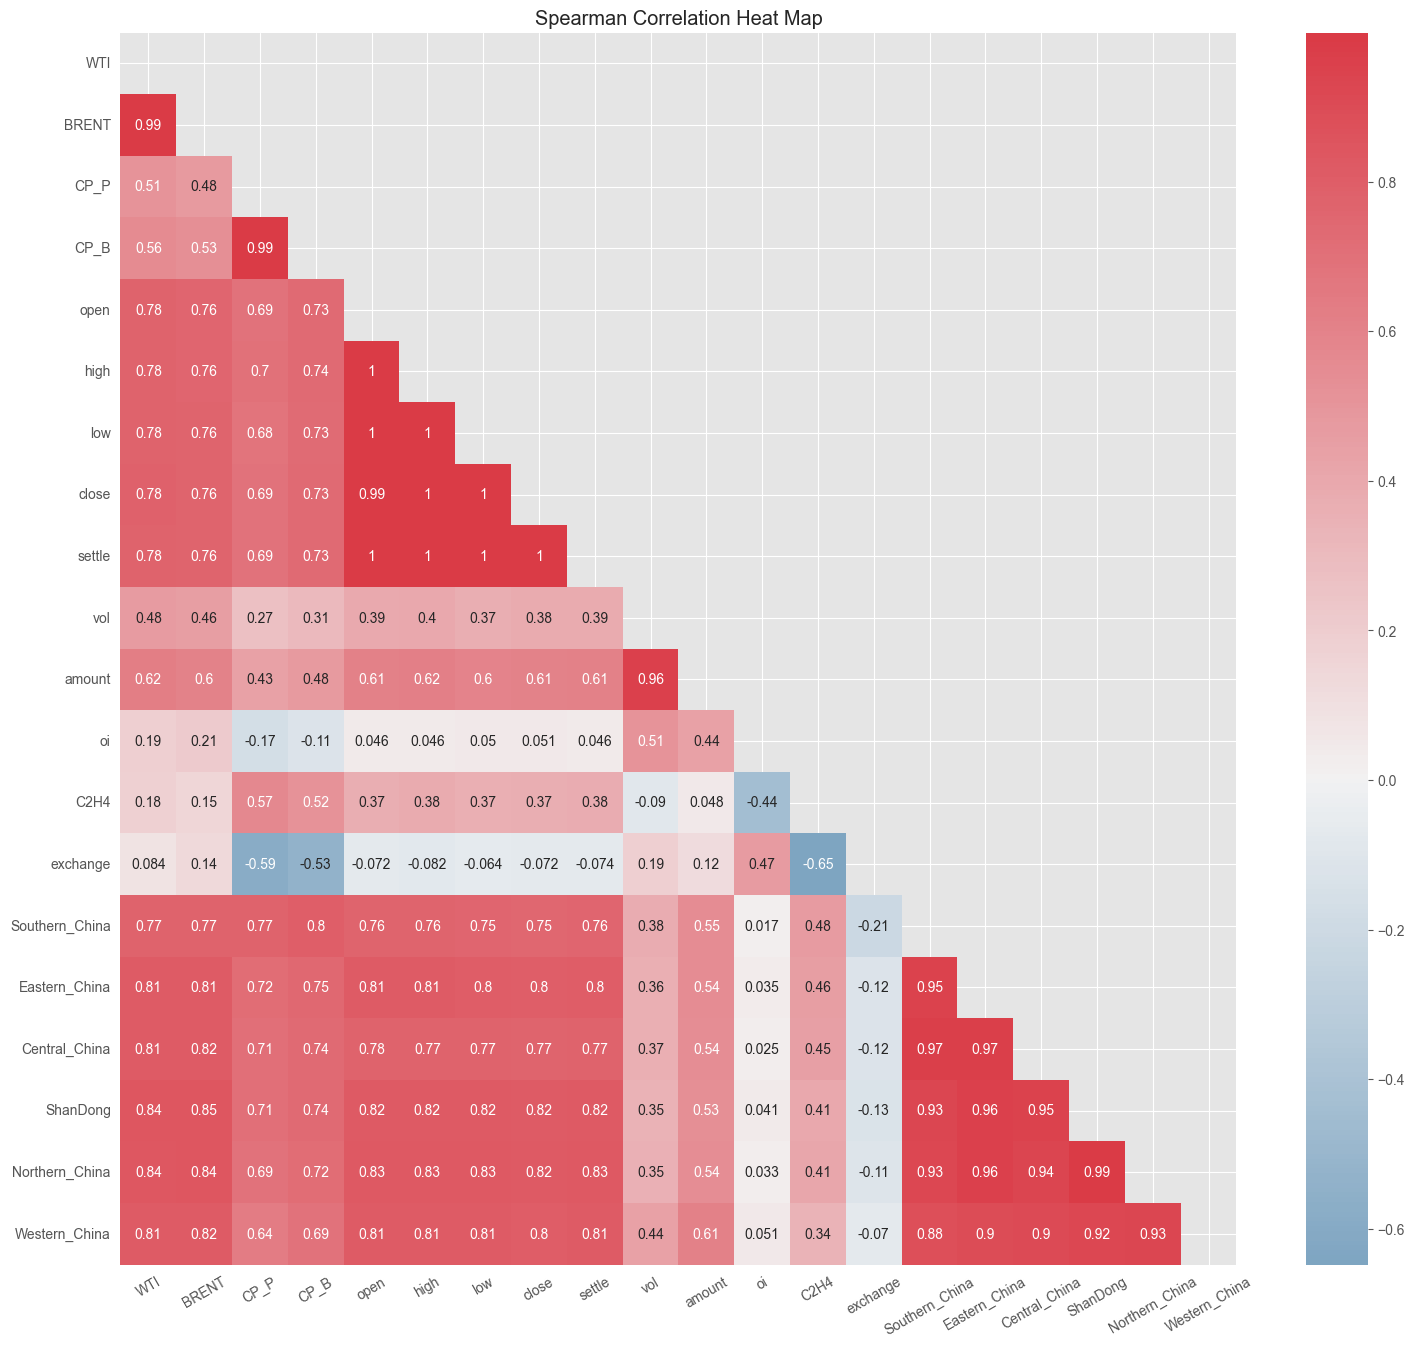

In [8]:
df2 = df[df['unique_id'] == 'Southern_China'][['WTI', 'BRENT', 'CP_P', 'CP_B', 'open', 'high', 'low', 'close', 'settle', 'vol', 'amount', 'oi', 'C2H4', 'exchange']]
for i in uids:
    df2[f'{i}'] = df[df['unique_id'] == i]['y']
cor = df2.corr(method='spearman')
plt.figure(figsize=(18, 16))
cmap = sns.diverging_palette(240, 10, n=9, center='light', as_cmap=True)
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cor,mask=mask, annot=True, cmap=cmap, center=0)
plt.xticks(rotation=30)
plt.title('Spearman Correlation Heat Map')
# plt.savefig('产品价格相关性热力图.png')
plt.show()

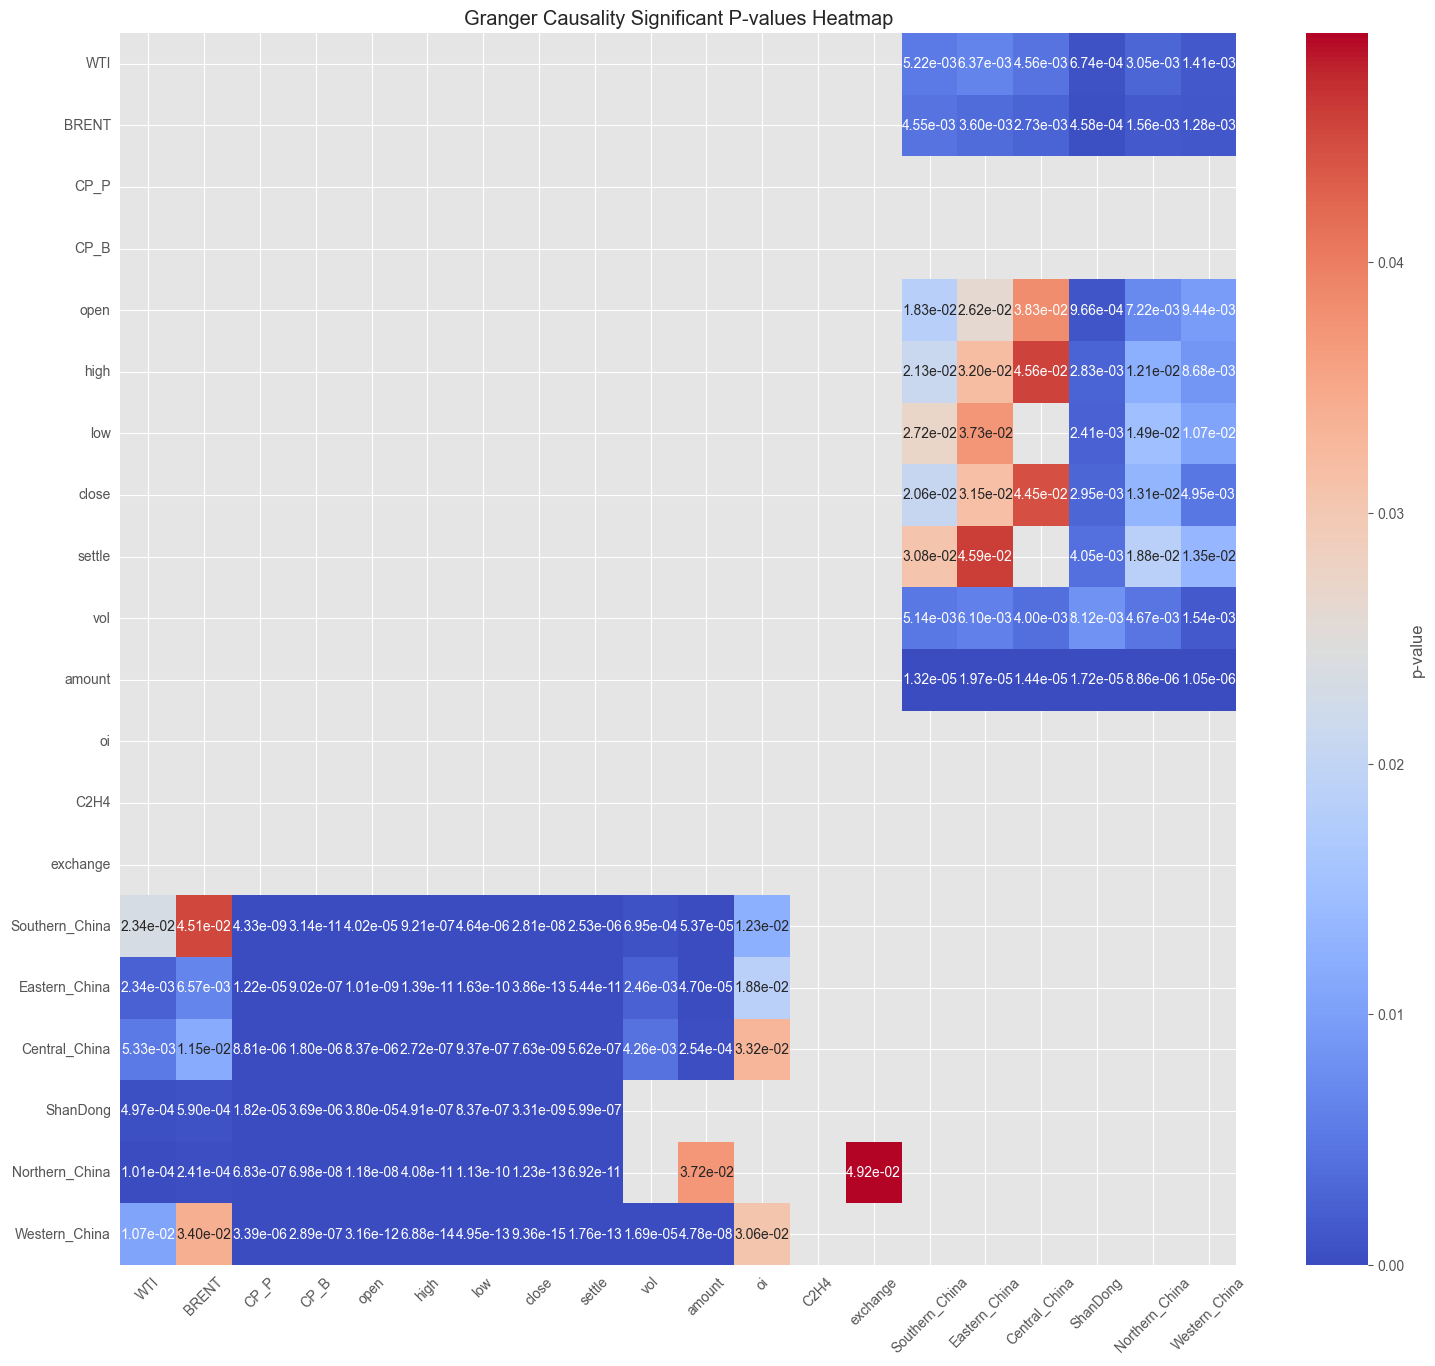

In [9]:
# 定义因变量和自变量组
independent_vars = ['WTI', 'BRENT', 'CP_P', 'CP_B', 'open', 'high', 'low', 'close', 'settle', 'vol', 'amount', 'oi', 'C2H4', 'exchange']
dependent_vars = ['Southern_China', 'Eastern_China', 'Central_China', 'ShanDong', 'Northern_China', 'Western_China']

# 初始化一个空的DataFrame来存储结果
results_df = pd.DataFrame()
lag = 1
# 进行Granger因果关系检测
for y in dependent_vars:
    for x in independent_vars:
        # 检测x对y的影响（x => y）
        result_xy = grangercausalitytests(df2[[y, x]], maxlag=lag, verbose=False)
        f_stat_xy = result_xy[lag][0]['ssr_chi2test'][0]
        p_value_xy = result_xy[lag][0]['ssr_chi2test'][1]

        # 检测y对x的影响（y => x）
        result_yx = grangercausalitytests(df2[[x, y]], maxlag=lag, verbose=False)
        f_stat_yx = result_yx[lag][0]['ssr_chi2test'][0]
        p_value_yx = result_yx[lag][0]['ssr_chi2test'][1]

        # 将结果添加到DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({
            'Dependent': [y, x],
            'Independent': [x, y],
            'Direction': ['x => y', 'y => x'],
            'Lag': [4, 4],
            'F-Statistic': [f_stat_xy, f_stat_yx],
            'p-value': [p_value_xy, p_value_yx]
        })], ignore_index=True)

significant_results = results_df[results_df['p-value'] < 0.05]
# 指定变量顺序
ordered_vars = ['WTI', 'BRENT', 'CP_P', 'CP_B', 'open', 'high', 'low', 'close',
                'settle', 'vol', 'amount', 'oi', 'C2H4', 'exchange', 'Southern_China',
                'Eastern_China', 'Central_China', 'ShanDong', 'Northern_China',
                'Western_China']

# 创建空的DataFrame，行和列均为指定的变量
p_values_matrix = pd.DataFrame(index=ordered_vars, columns=ordered_vars, data=np.nan)

# 假设significant_results是已经得到的含有显著p-values的DataFrame
# 逐个填充已知的p-value到矩阵中
for _, row in significant_results.iterrows():
    if row['Dependent'] in ordered_vars and row['Independent'] in ordered_vars:
        p_values_matrix.loc[row['Dependent'], row['Independent']] = row['p-value']

# 绘制热力图
plt.figure(figsize=(18, 16))
sns.heatmap(p_values_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'p-value'}, fmt=".2e")
plt.title('Granger Causality Significant P-values Heatmap')
plt.xticks(rotation=45)  # 旋转x轴标签
plt.yticks(rotation=0)
plt.show()

In [10]:
def predict_future(model, data, _uids, period, _step_size=1, _h=30):
    result = pd.DataFrame()
    date_list = list(range(period[0],period[1]-_h,_step_size))
    date_list.append(period[1]-_h)
    for i in date_list:
        input = data[data['ds'] < data['ds'][i]]
        output = model.predict(input, static_df=static_df, futr_df = df[['unique_id','ds','year', 'month', 'day', 'day_of_week', 'week_of_year', 'quarter', 'season', 'is_weekend', 'is_holiday']])
        output['cutoff'] = data['ds'][i-1]
        output['y'] = 0
        output.reset_index(inplace=True)
        for j in _uids:
            output.loc[output['unique_id'] == j, 'y'] = data[data['unique_id'] == j]['y'].tolist()[i:i+_h]
        result = pd.concat([result, output], axis=0)
    result.reset_index(inplace=True)
    result = result.sort_values(by = ['unique_id', 'ds'])
    return result
def DOC(test_result, model_list, df_s):
  date_start = test_result['cutoff'].unique()
  cols = []
  for i in model_list:
    cols.append(i+' p_value')
  cols = model_list + cols
  output = pd.DataFrame(index=uids, columns=cols)
  for k in model_list:
    for i in test_result['unique_id'].unique():
      a, b =pd.Series(), pd.Series()
      for j in date_start:
        a = pd.concat([a, test_result[(test_result['unique_id'] == i) & (test_result['cutoff'] == j)][k] - df_s[(df_s['unique_id'] == i) & (df_s['ds'] == j)]['y'].item()], axis=0)
        b = pd.concat([b, test_result[(test_result['unique_id'] == i) & (test_result['cutoff'] == j)]['y'] - df_s[(df_s['unique_id'] == i) & (df_s['ds'] == j)]['y'].item()], axis=0)
      res = a*b
      res = res[res!=0]
      res = res.apply(lambda x: 1 if x > 0 else 0)
      output.loc[i,k] = res.mean()
      filter = a*b
      filter = filter.apply(lambda x: 1 if x != 0 else 0)
      a,b = a * filter, b * filter
      a = a[a!=0]
      b = b[b!=0]
      a = a.apply(lambda x: 1 if x > 0 else 0)
      b = b.apply(lambda x: 1 if x > 0 else 0)
      table = [[1,1],[1,1]]
      x, y = list(a), list(b)
      for (q, w) in zip(y, x):
        table[q][w] += 1
      chi2, p, dof, _ = chi(table)
      output.loc[i,k+' p_value'] = p
  return output
def OWA(pred, true, naive_pred, train_y):
    smape = 2*np.mean(np.abs((pred - true) / (np.abs(true)+np.abs(pred))))
    mase = np.mean(np.abs(pred-true))/np.mean(np.abs(np.diff(train_y)))
    smape_n = 2*np.mean(np.abs((naive_pred - true) / (np.abs(true)+np.abs(naive_pred))))
    mase_n = np.mean(np.abs(naive_pred-true))/np.mean(np.abs(np.diff(train_y)))
    owa = (smape/smape_n+mase/mase_n)/2
    return owa

In [11]:
path = 'data_LPG.xlsx'
df=pd.read_excel(path,engine="openpyxl")
df = df[['ds','unique_id','y','WTI','BRENT','沙特阿美预测CP(丙烷)','沙特阿美预测CP(丁烷)','open','high','low','close','settle','vol','amount','oi','乙烯价格','中国:中间价:美元兑人民币']]
df.columns = ['ds','unique_id','y','WTI','BRENT','CP_P','CP_B','open','high','low','close','settle','vol','amount','oi','C2H4','exchange']
df['unique_id'].replace('华南', 'Southern_China', inplace=True)
df['unique_id'].replace('华东', 'Eastern_China', inplace=True)
df['unique_id'].replace('华中', 'Central_China', inplace=True)
df['unique_id'].replace('山东', 'ShanDong', inplace=True)
df['unique_id'].replace('华北', 'Northern_China', inplace=True)
df['unique_id'].replace('西部', 'Western_China', inplace=True)
df = df[df['ds'] < '2024-01-16'].reset_index(drop=True)
uids = df['unique_id'].unique()
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['day_of_week'] = df['ds'].dt.dayofweek
df['week_of_year'] = df['ds'].dt.isocalendar().week
df['quarter'] = df['ds'].dt.quarter
df['season'] = df['month'].apply(lambda x: (x%12 + 3)//3)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_holiday'] = 0
static_list = ['year', 'month', 'day', 'day_of_week', 'week_of_year', 'quarter', 'season', 'is_weekend', 'is_holiday']
holidays = {
    'New Year': ['2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01'],
    'Spring Festival': ['2021-02-11', '2022-02-01', '2023-01-22', '2024-02-10'],
    'Labor Day': ['2021-05-01', '2022-05-01', '2023-05-01', '2024-05-01'],
    'Dragon Boat Festival': ['2021-06-14', '2022-06-03', '2023-06-22', '2024-06-10'],
    'Mid-Autumn Festival': ['2021-09-21', '2022-09-10', '2023-09-29', '2024-09-17'],
    'National Day': ['2021-10-01', '2022-10-01', '2023-10-01', '2024-10-01']
}
holiday_durations = {
    'New Year': 1,
    'Spring Festival': 7,
    'Labor Day': 3,
    'Dragon Boat Festival': 1,
    'Mid-Autumn Festival': 1,
    'National Day': 7
}
# 生成假期日期
extended_holidays = {}
for holiday, dates in holidays.items():
    for date in dates:
        start_date = pd.to_datetime(date)
        duration = holiday_durations[holiday]
        holiday_period = pd.date_range(start=start_date, periods=duration)
        extended_holidays[holiday] = extended_holidays.get(holiday, []) + list(holiday_period)

# 创建整个日期范围的DataFrame
date_range_full = pd.date_range(start='2021-01-01', end='2024-01-16')
df_full_date_range = pd.DataFrame(date_range_full, columns=['date'])

# 将所有假期日期合并为一个列表
extended_holiday_dates = [date for dates in extended_holidays.values() for date in dates]

# 标记是否为假期
df_full_date_range['is_holiday'] = df_full_date_range['date'].isin(extended_holiday_dates).astype(int)

# 添加假期名称
df_full_date_range['holiday_name'] = df_full_date_range['date'].apply(
    lambda x: [holiday for holiday, dates in extended_holidays.items() if x in dates][0] if x in extended_holiday_dates else None
)
for i in range(0, len(df)):
  if df_full_date_range['is_holiday'][i%1110] == 1:
    df.loc[i, 'is_holiday'] = 1
unit_matrix = np.eye(6)
uids_series = pd.Series(uids)
static_df = pd.DataFrame(unit_matrix, columns = ['market_0', 'market_1', 'market_2', 'market_3', 'market_4', 'market_5'])
static_df['unique_id'] = uids
# 假设你的DataFrame名为df
cols = static_df.columns.tolist()
# 把最后一列的名字移到列表的开头
cols = [cols[-1]] + cols[:-1]
# 使用这个新的列顺序来重新排列DataFrame
static_df = static_df[cols]
train_size = 810
h = 30
step_size = h
metric_south = pd.DataFrame()
nf = NeuralForecast.load(f'models/TRANS24')
left = df['ds'][810]
right = df['ds'][1109]
df_i = df.set_index('ds')
row = 1
plt.figure(figsize=(16, 9 * row))
n = 0
train = nf.predict_insample()
train = train.reset_index()
test = predict_future(nf, df, _uids=uids, period=[train_size, int(len(df)/6)], _step_size=step_size, _h=h)
naive_date = test['cutoff'].unique()
train.columns =  [col.replace('Auto', '', 1) for col in train.columns]
test.columns =  [col.replace('Auto', '', 1) for col in test.columns]
plt.figure(figsize=(16, 9 * row))
num_folds = 10
fold_duration = (right - left) / num_folds
fold_lines = [left + i * fold_duration for i in range(1, num_folds)]
j, model = 'Autoformer', 'Autoformer'
i = 'Southern_China'
ax = plt.subplot(row, 1, n+1)
plt.title(f'{j}_{i}_Forecasting')
plt.plot(df_i[df_i['unique_id'] == i]['y'], label='real')
plt.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='in_sample')
clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_train'].item(), 2)}_{j}_Train")
plt.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='out_of_sample')
clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_test'].item(), 2)}_{j}_Test")
plt.xticks(rotation=15)
plt.ylim(0,8000)
plt.legend(loc='upper right')
axins = inset_axes(ax, width="30%", height="30%", loc='lower center',
            bbox_to_anchor=(-0.1, -0.01, 1.68, 1.3), bbox_transform=ax.transAxes)  # 位置调整
axins.plot(df_i[df_i['unique_id'] == i]['y'], label='real_inset')
axins.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Train_inset")
axins.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Test_inset")
axins.set_xticks([])
axins.set_xlim(left, right)
for line in fold_lines:
    axins.axvline(x=line, color='red', linestyle='--', linewidth=1)
temp = test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1).to_frame()
top1 = np.max(temp[(temp.index>left)&(temp.index<right)].values)
bottom1 = np.min(temp[(temp.index>left)&(temp.index<right)].values)
top2 = np.max(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
bottom2 = np.min(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
top = np.max([top1, top2])
bottom = np.min([bottom1, bottom2])
axins.set_ylim(bottom,top)
axins.spines['bottom'].set_color('red')  # 设置下边框颜色
axins.spines['top'].set_color('red')     # 设置上边框颜色
axins.spines['left'].set_color('red')    # 设置左边框颜色
axins.spines['right'].set_color('red')   # 设置右边桜颜色
con1 = ConnectionPatch(xyA=(left, top), xyB=(left, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
con2 = ConnectionPatch(xyA=(right, top), xyB=(right, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
rect = Rectangle((left, bottom), right-left, top-bottom, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_artist(con1)
ax.add_artist(con2)
n += 1
clear_output(wait=False)
plt.show()
naive_m = pd.DataFrame()
for k in uids:
  naive_result = []
  for date in naive_date:
    temp = df[df['ds'] == date][df['unique_id'] == k]['y'].item()
    for www in range(30):
      naive_result.append(temp)
  naive_m[k] = naive_result
mae = mc.MAE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
rmse = mc.RMSE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
mape = mc.MAPE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
owa = OWA(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']),np.array(naive_m[i]),np.array(df[df['unique_id'] == i][:810]['y']))
doc = DOC(test,[model],df)
print(f'MAE:{mae}\nRMSE:{rmse}\nMAPE:{mape*100}\nOWA:{owa}\nDS:{doc.loc[i,model]*100}')

Seed set to 5
Seed set to 18
Seed set to 14
Seed set to 3
Seed set to 11
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: D:\Projects\Paper\lightning_logs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

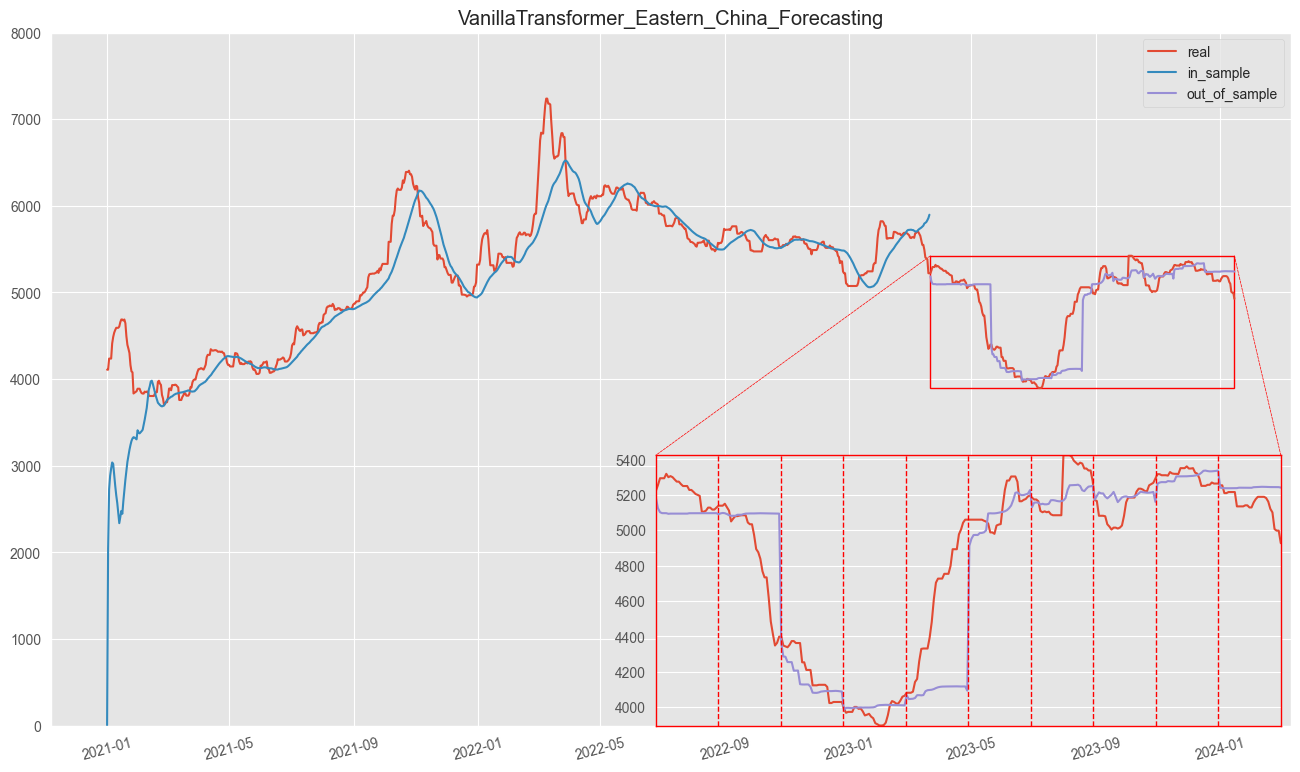

MAE:134.559130859375
RMSE:228.30457434145524
MAPE:2.7881528359286265
OWA:0.8489104534754961
DS:80.0


In [18]:
nf = NeuralForecast.load(f'models/TRANS2')
left = df['ds'][810]
right = df['ds'][1109]
df_i = df.set_index('ds')
row = 1
plt.figure(figsize=(16, 9 * row))
n = 0
train = nf.predict_insample()
train = train.reset_index()
test = predict_future(nf, df, _uids=uids, period=[train_size, int(len(df)/6)], _step_size=step_size, _h=h)
train.columns =  [col.replace('Auto', '', 1) for col in train.columns]
test.columns =  [col.replace('Auto', '', 1) for col in test.columns]
plt.figure(figsize=(16, 9 * row))
num_folds = 10
fold_duration = (right - left) / num_folds
fold_lines = [left + i * fold_duration for i in range(1, num_folds)]
n = 0
j, model = 'VanillaTransformer', 'VanillaTransformer'
i = 'Eastern_China'
ax = plt.subplot(row, 1, n+1)
plt.title(f'{j}_{i}_Forecasting')
plt.plot(df_i[df_i['unique_id'] == i]['y'], label='real')
plt.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='in_sample')
# clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_train'].item(), 2)}_{j}_Train")
plt.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='out_of_sample')
clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_test'].item(), 2)}_{j}_Test")
plt.xticks(rotation=15)
plt.ylim(0,8000)
plt.legend(loc='upper right')
axins = inset_axes(ax, width="30%", height="30%", loc='lower center',
            bbox_to_anchor=(-0.1, -0.01, 1.68, 1.3), bbox_transform=ax.transAxes)  # 位置调整
axins.plot(df_i[df_i['unique_id'] == i]['y'], label='real_inset')
axins.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Train_inset")
axins.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Test_inset")
axins.set_xticks([])
axins.set_xlim(left, right)
for line in fold_lines:
    axins.axvline(x=line, color='red', linestyle='--', linewidth=1)
temp = test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1).to_frame()
top1 = np.max(temp[(temp.index>left)&(temp.index<right)].values)
bottom1 = np.min(temp[(temp.index>left)&(temp.index<right)].values)
top2 = np.max(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
bottom2 = np.min(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
top = np.max([top1, top2])
bottom = np.min([bottom1, bottom2])
axins.set_ylim(bottom,top)
axins.spines['bottom'].set_color('red')  # 设置下边框颜色
axins.spines['top'].set_color('red')     # 设置上边框颜色
axins.spines['left'].set_color('red')    # 设置左边框颜色
axins.spines['right'].set_color('red')   # 设置右边桜颜色
con1 = ConnectionPatch(xyA=(left, top), xyB=(left, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
con2 = ConnectionPatch(xyA=(right, top), xyB=(right, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
rect = Rectangle((left, bottom), right-left, top-bottom, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_artist(con1)
ax.add_artist(con2)
n += 1
clear_output(wait=False)
plt.show()
mae = mc.MAE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
rmse = mc.RMSE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
mape = mc.MAPE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
owa = OWA(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']),np.array(naive_m[i]),np.array(df[df['unique_id'] == i][:810]['y']))
doc = DOC(test,[model],df)
print(f'MAE:{mae}\nRMSE:{rmse}\nMAPE:{mape*100}\nOWA:{owa}\nDS:{doc.loc[i,model]*100}')

<Figure size 1600x900 with 0 Axes>

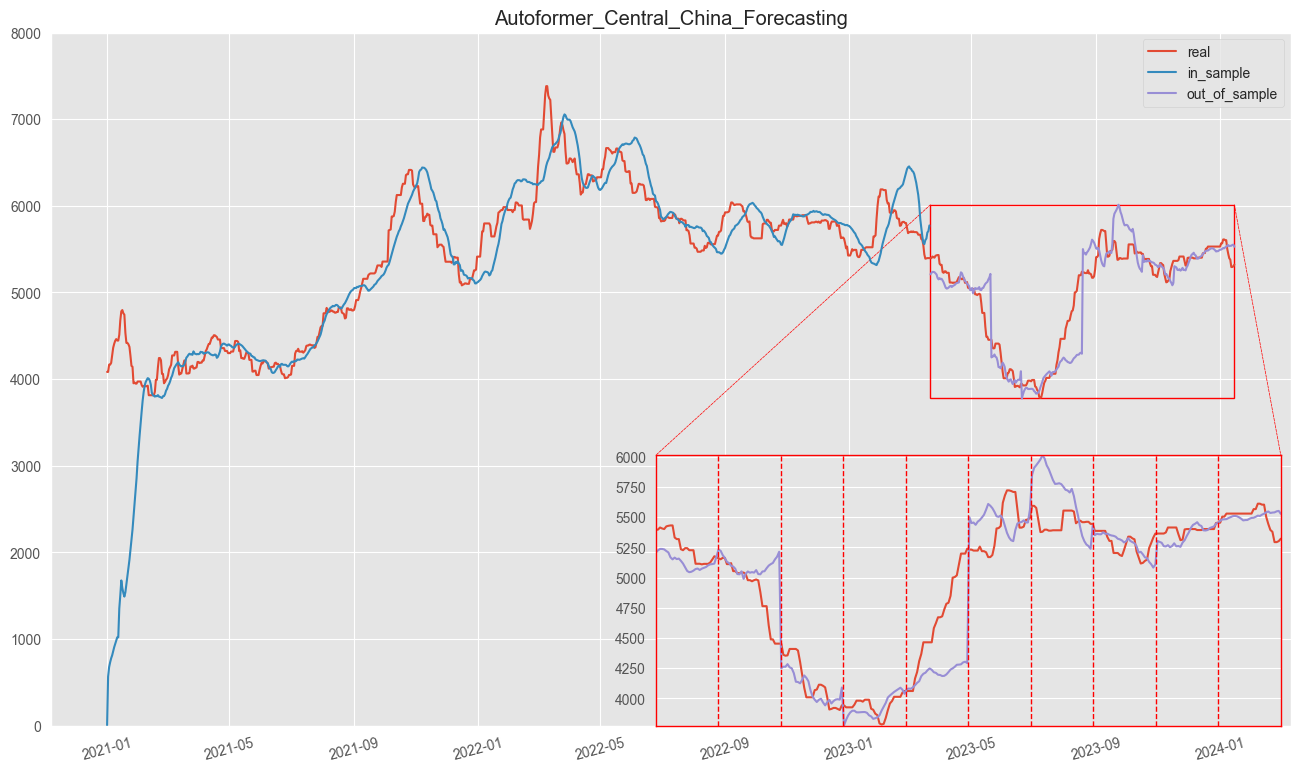

MAE:168.00087809244792
RMSE:252.57698668623033
MAPE:3.3789009808008585
OWA:0.8640481408510519
DS:78.397212543554


In [19]:
nf = NeuralForecast.load(f'models/TRANS4')
left = df['ds'][810]
right = df['ds'][1109]
df_i = df.set_index('ds')
row = 1
plt.figure(figsize=(16, 9 * row))
n = 0
train = nf.predict_insample()
train = train.reset_index()
test = predict_future(nf, df, _uids=uids, period=[train_size, int(len(df)/6)], _step_size=step_size, _h=h)
train.columns =  [col.replace('Auto', '', 1) for col in train.columns]
test.columns =  [col.replace('Auto', '', 1) for col in test.columns]
plt.figure(figsize=(16, 9 * row))
num_folds = 10
fold_duration = (right - left) / num_folds
fold_lines = [left + i * fold_duration for i in range(1, num_folds)]
n = 0
j, model = 'Autoformer', 'Autoformer'
i = 'Central_China'
ax = plt.subplot(row, 1, n+1)
plt.title(f'{j}_{i}_Forecasting')
plt.plot(df_i[df_i['unique_id'] == i]['y'], label='real')
plt.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='in_sample')
# clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_train'].item(), 2)}_{j}_Train")
plt.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='out_of_sample')
clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_test'].item(), 2)}_{j}_Test")
plt.xticks(rotation=15)
plt.ylim(0,8000)
plt.legend(loc='upper right')
axins = inset_axes(ax, width="30%", height="30%", loc='lower center',
            bbox_to_anchor=(-0.1, -0.01, 1.68, 1.3), bbox_transform=ax.transAxes)  # 位置调整
axins.plot(df_i[df_i['unique_id'] == i]['y'], label='real_inset')
axins.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Train_inset")
axins.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Test_inset")
axins.set_xticks([])
axins.set_xlim(left, right)
for line in fold_lines:
    axins.axvline(x=line, color='red', linestyle='--', linewidth=1)
temp = test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1).to_frame()
top1 = np.max(temp[(temp.index>left)&(temp.index<right)].values)
bottom1 = np.min(temp[(temp.index>left)&(temp.index<right)].values)
top2 = np.max(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
bottom2 = np.min(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
top = np.max([top1, top2])
bottom = np.min([bottom1, bottom2])
axins.set_ylim(bottom,top)
axins.spines['bottom'].set_color('red')  # 设置下边框颜色
axins.spines['top'].set_color('red')     # 设置上边框颜色
axins.spines['left'].set_color('red')    # 设置左边框颜色
axins.spines['right'].set_color('red')   # 设置右边桜颜色
con1 = ConnectionPatch(xyA=(left, top), xyB=(left, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
con2 = ConnectionPatch(xyA=(right, top), xyB=(right, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
rect = Rectangle((left, bottom), right-left, top-bottom, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_artist(con1)
ax.add_artist(con2)
n += 1
clear_output(wait=False)
plt.show()
mae = mc.MAE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
rmse = mc.RMSE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
mape = mc.MAPE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
owa = OWA(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']),np.array(naive_m[i]),np.array(df[df['unique_id'] == i][:810]['y']))
doc = DOC(test,[model],df)
print(f'MAE:{mae}\nRMSE:{rmse}\nMAPE:{mape*100}\nOWA:{owa}\nDS:{doc.loc[i,model]*100}')

<Figure size 1600x900 with 0 Axes>

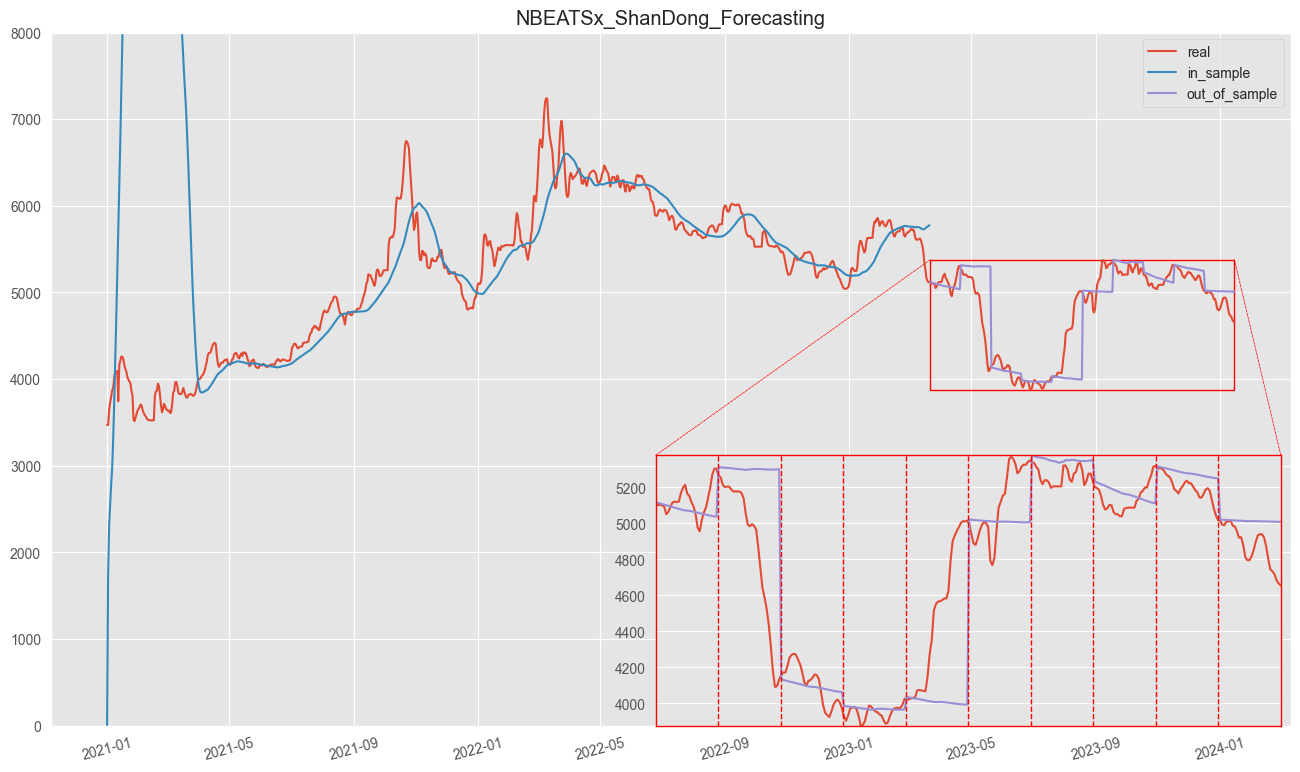

MAE:168.1030021158854
RMSE:289.09114592400886
MAPE:3.532980529146253
OWA:0.9798434102840093
DS:59.59595959595959


In [22]:
nf = NeuralForecast.load(f'models/MMN25')
left = df['ds'][810]
right = df['ds'][1109]
df_i = df.set_index('ds')
row = 1
plt.figure(figsize=(16, 9 * row))
n = 0
train = nf.predict_insample()
train = train.reset_index()
test = predict_future(nf, df, _uids=uids, period=[train_size, int(len(df)/6)], _step_size=step_size, _h=h)
train.columns =  [col.replace('Auto', '', 1) for col in train.columns]
test.columns =  [col.replace('Auto', '', 1) for col in test.columns]
plt.figure(figsize=(16, 9 * row))
num_folds = 10
fold_duration = (right - left) / num_folds
fold_lines = [left + i * fold_duration for i in range(1, num_folds)]
n = 0
j, model = 'NBEATSx', 'NBEATSx'
i = 'ShanDong'
ax = plt.subplot(row, 1, n+1)
plt.title(f'{j}_{i}_Forecasting')
plt.plot(df_i[df_i['unique_id'] == i]['y'], label='real')
plt.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='in_sample')
# clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_train'].item(), 2)}_{j}_Train")
plt.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='out_of_sample')
clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_test'].item(), 2)}_{j}_Test")
plt.xticks(rotation=15)
plt.ylim(0,8000)
plt.legend(loc='upper right')
axins = inset_axes(ax, width="30%", height="30%", loc='lower center',
            bbox_to_anchor=(-0.1, -0.01, 1.68, 1.3), bbox_transform=ax.transAxes)  # 位置调整
axins.plot(df_i[df_i['unique_id'] == i]['y'], label='real_inset')
axins.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Train_inset")
axins.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Test_inset")
axins.set_xticks([])
axins.set_xlim(left, right)
for line in fold_lines:
    axins.axvline(x=line, color='red', linestyle='--', linewidth=1)
temp = test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1).to_frame()
top1 = np.max(temp[(temp.index>left)&(temp.index<right)].values)
bottom1 = np.min(temp[(temp.index>left)&(temp.index<right)].values)
top2 = np.max(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
bottom2 = np.min(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
top = np.max([top1, top2])
bottom = np.min([bottom1, bottom2])
axins.set_ylim(bottom,top)
axins.spines['bottom'].set_color('red')  # 设置下边框颜色
axins.spines['top'].set_color('red')     # 设置上边框颜色
axins.spines['left'].set_color('red')    # 设置左边框颜色
axins.spines['right'].set_color('red')   # 设置右边桜颜色
con1 = ConnectionPatch(xyA=(left, top), xyB=(left, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
con2 = ConnectionPatch(xyA=(right, top), xyB=(right, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
rect = Rectangle((left, bottom), right-left, top-bottom, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_artist(con1)
ax.add_artist(con2)
n += 1
clear_output(wait=False)
plt.show()
mae = mc.MAE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
rmse = mc.RMSE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
mape = mc.MAPE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
owa = OWA(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']),np.array(naive_m[i]),np.array(df[df['unique_id'] == i][:810]['y']))
doc = DOC(test,[model],df)
print(f'MAE:{mae}\nRMSE:{rmse}\nMAPE:{mape*100}\nOWA:{owa}\nDS:{doc.loc[i,model]*100}')

<Figure size 1600x900 with 0 Axes>

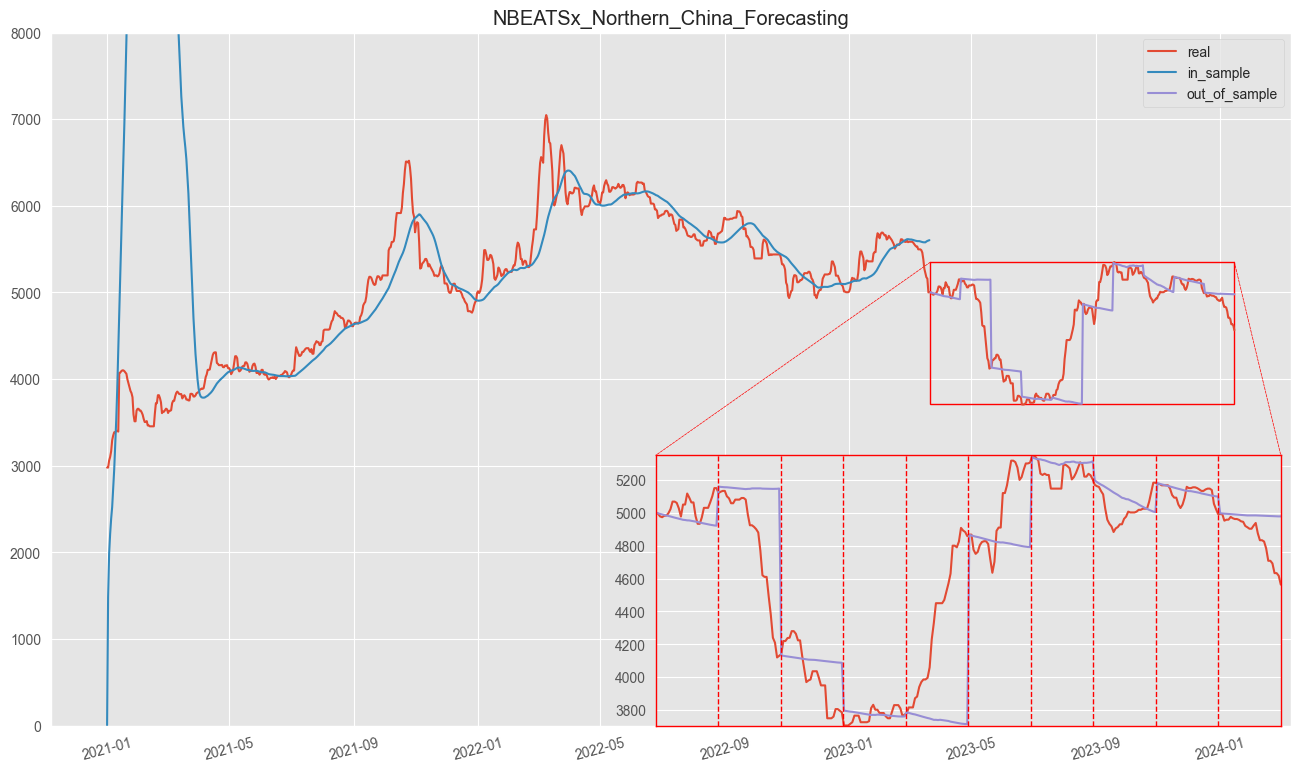

MAE:177.18738444010415
RMSE:305.704840333627
MAPE:3.8288395383512634
OWA:0.9786669263628123
DS:61.82432432432432


In [23]:
nf = NeuralForecast.load(f'models/MMN25')
left = df['ds'][810]
right = df['ds'][1109]
df_i = df.set_index('ds')
row = 1
plt.figure(figsize=(16, 9 * row))
n = 0
# train = predict_future(nf, df, _uids=uids, period = [1, train_size], _step_size=step_size, _h=h)
train = nf.predict_insample()
train = train.reset_index()
test = predict_future(nf, df, _uids=uids, period=[train_size, int(len(df)/6)], _step_size=step_size, _h=h)
naive_date = test['cutoff'].unique()
train.columns =  [col.replace('Auto', '', 1) for col in train.columns]
test.columns =  [col.replace('Auto', '', 1) for col in test.columns]
plt.figure(figsize=(16, 9 * row))
num_folds = 10
fold_duration = (right - left) / num_folds
fold_lines = [left + i * fold_duration for i in range(1, num_folds)]
n = 0
j, model = 'NBEATSx', 'NBEATSx'
i = 'Northern_China'
ax = plt.subplot(row, 1, n+1)
plt.title(f'{j}_{i}_Forecasting')
plt.plot(df_i[df_i['unique_id'] == i]['y'], label='real')
plt.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='in_sample')
# clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_train'].item(), 2)}_{j}_Train")
plt.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='out_of_sample')
clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_test'].item(), 2)}_{j}_Test")
plt.xticks(rotation=15)
plt.ylim(0,8000)
plt.legend(loc='upper right')
axins = inset_axes(ax, width="30%", height="30%", loc='lower center',
            bbox_to_anchor=(-0.1, -0.01, 1.68, 1.3), bbox_transform=ax.transAxes)  # 位置调整
axins.plot(df_i[df_i['unique_id'] == i]['y'], label='real_inset')
axins.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Train_inset")
axins.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Test_inset")
axins.set_xticks([])
axins.set_xlim(left, right)
for line in fold_lines:
    axins.axvline(x=line, color='red', linestyle='--', linewidth=1)
temp = test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1).to_frame()
top1 = np.max(temp[(temp.index>left)&(temp.index<right)].values)
bottom1 = np.min(temp[(temp.index>left)&(temp.index<right)].values)
top2 = np.max(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
bottom2 = np.min(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
top = np.max([top1, top2])
bottom = np.min([bottom1, bottom2])
axins.set_ylim(bottom,top)
axins.spines['bottom'].set_color('red')  # 设置下边框颜色
axins.spines['top'].set_color('red')     # 设置上边框颜色
axins.spines['left'].set_color('red')    # 设置左边框颜色
axins.spines['right'].set_color('red')   # 设置右边桜颜色
con1 = ConnectionPatch(xyA=(left, top), xyB=(left, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
con2 = ConnectionPatch(xyA=(right, top), xyB=(right, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
rect = Rectangle((left, bottom), right-left, top-bottom, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_artist(con1)
ax.add_artist(con2)
n += 1
clear_output(wait=False)
plt.show()
mae = mc.MAE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
rmse = mc.RMSE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
mape = mc.MAPE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
owa = OWA(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']),np.array(naive_m[i]),np.array(df[df['unique_id'] == i][:810]['y']))
doc = DOC(test,[model],df)
print(f'MAE:{mae}\nRMSE:{rmse}\nMAPE:{mape*100}\nOWA:{owa}\nDS:{doc.loc[i,model]*100}')

<Figure size 1600x900 with 0 Axes>

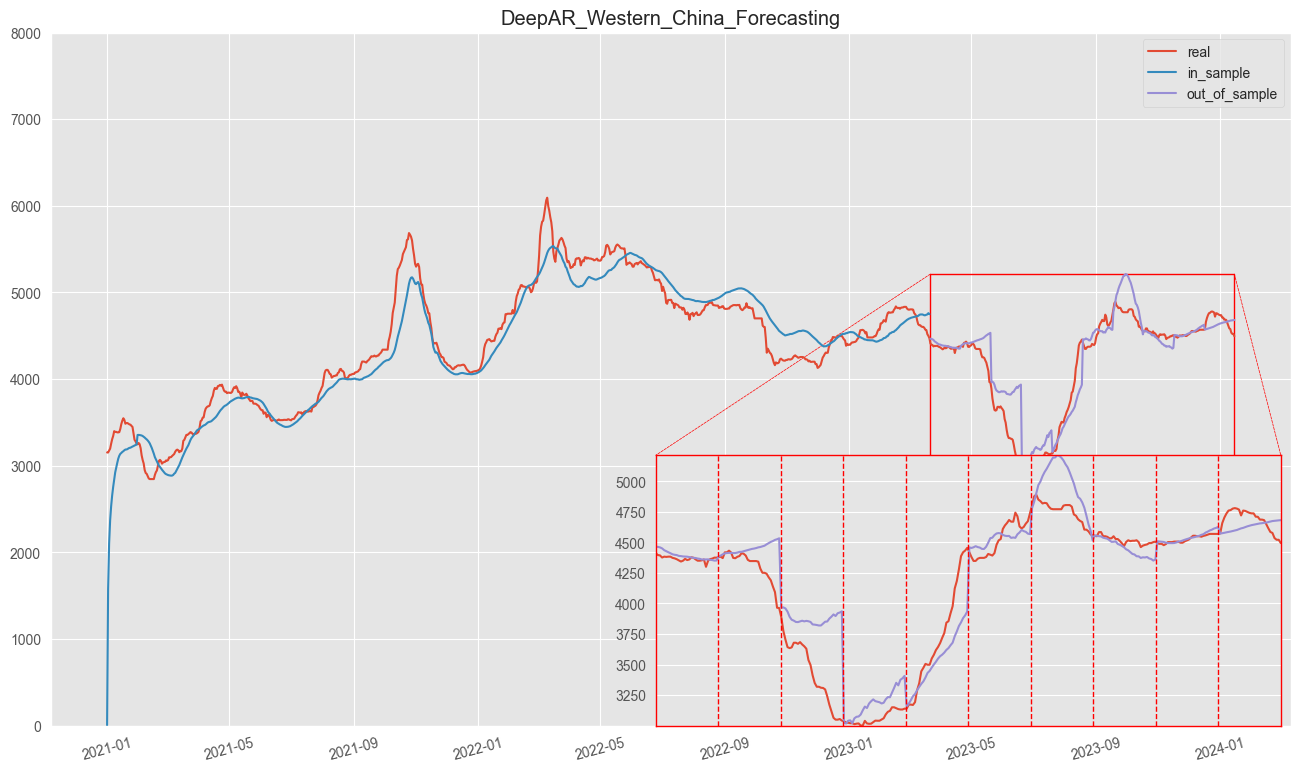

MAE:145.0109383138021
RMSE:223.73378733092332
MAPE:3.7526188802143414
OWA:0.8153302496746391
DS:79.66101694915254


In [24]:
nf = NeuralForecast.load(f'models/RNN1')
left = df['ds'][810]
right = df['ds'][1109]
df_i = df.set_index('ds')
row = 1
plt.figure(figsize=(16, 9 * row))
n = 0
train = nf.predict_insample()
train = train.reset_index()
test = predict_future(nf, df, _uids=uids, period=[train_size, int(len(df)/6)], _step_size=step_size, _h=h)
train.columns =  [col.replace('Auto', '', 1) for col in train.columns]
test.columns =  [col.replace('Auto', '', 1) for col in test.columns]
plt.figure(figsize=(16, 9 * row))
num_folds = 10
fold_duration = (right - left) / num_folds
fold_lines = [left + i * fold_duration for i in range(1, num_folds)]
n = 0
j, model = 'DeepAR', 'DeepAR'
i = 'Western_China'
ax = plt.subplot(row, 1, n+1)
plt.title(f'{j}_{i}_Forecasting')
plt.plot(df_i[df_i['unique_id'] == i]['y'], label='real')
plt.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='in_sample')
clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_train'].item(), 2)}_{j}_Train")
plt.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),label='out_of_sample')
clear_output(wait=False)
          # label=f"{round(results.loc[(results['metric'] == 'MAE') & (results.index == i), f'{j}_test'].item(), 2)}_{j}_Test")
plt.xticks(rotation=15)
plt.ylim(0,8000)
plt.legend(loc='upper right')
axins = inset_axes(ax, width="30%", height="30%", loc='lower center',
            bbox_to_anchor=(-0.1, -0.01, 1.68, 1.3), bbox_transform=ax.transAxes)  # 位置调整
axins.plot(df_i[df_i['unique_id'] == i]['y'], label='real_inset')
axins.plot(train[train['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Train_inset")
axins.plot(test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1),
            label=f"{model}_Test_inset")
axins.set_xticks([])
axins.set_xlim(left, right)
for line in fold_lines:
    axins.axvline(x=line, color='red', linestyle='--', linewidth=1)
temp = test[test['unique_id'] == i][['ds', 'cutoff', model]].pivot(index='ds', columns='cutoff', values=model).mean(axis=1).to_frame()
top1 = np.max(temp[(temp.index>left)&(temp.index<right)].values)
bottom1 = np.min(temp[(temp.index>left)&(temp.index<right)].values)
top2 = np.max(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
bottom2 = np.min(df_i[(df_i['unique_id'] == i)&(df_i.index>left)&(df_i.index<right)]['y'])
top = np.max([top1, top2])
bottom = np.min([bottom1, bottom2])
axins.set_ylim(bottom,top)
axins.spines['bottom'].set_color('red')  # 设置下边框颜色
axins.spines['top'].set_color('red')     # 设置上边框颜色
axins.spines['left'].set_color('red')    # 设置左边框颜色
axins.spines['right'].set_color('red')   # 设置右边桜颜色
con1 = ConnectionPatch(xyA=(left, top), xyB=(left, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
con2 = ConnectionPatch(xyA=(right, top), xyB=(right, top),
                coordsA='data', coordsB='data',
                axesA=ax, axesB=axins, color='red',
                linestyle="--")
rect = Rectangle((left, bottom), right-left, top-bottom, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_artist(con1)
ax.add_artist(con2)
n += 1
clear_output(wait=False)
plt.show()
mae = mc.MAE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
rmse = mc.RMSE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
mape = mc.MAPE(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']))
owa = OWA(np.array(test[test['unique_id']==i][model]),np.array(test[test['unique_id']==i]['y']),np.array(naive_m[i]),np.array(df[df['unique_id'] == i][:810]['y']))
doc = DOC(test,[model],df)
print(f'MAE:{mae}\nRMSE:{rmse}\nMAPE:{mape*100}\nOWA:{owa}\nDS:{doc.loc[i,model]*100}')